In [10]:
from util.log import plot_ts_result, regression_results
from util.model import DQNAgent

import torch
import gym
from gym import spaces
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass

df = pd.read_csv("data/merged_fill.csv") 
df["INNER_HMDT"] = (df["INNER_HMDT_1"] + df["INNER_HMDT_2"]) / 2
df["INNER_TPRT"] = (df["INNER_TPRT_1"] + df["INNER_TPRT_2"]) / 2


In [11]:
x_cols = ["EXTN_TPRT", "INNER_HMDT"] 
y_cols = ["INNER_TPRT"]
pred_df_train = pd.read_csv(f"data/pred_{y_cols[0]}_train.csv")
pred_df_test = pd.read_csv(f"data/pred_{y_cols[0]}_test.csv")

In [12]:
class GreenhouseTSEnv(gym.Env):
    def __init__(self, data, tick=3): # data is a batch
        super(GreenhouseTSEnv, self).__init__()

        self.tick = tick
        self.history = data
        self.current_step = 0
        self.nums_data, input_size = data[0].shape
        self.max_steps = self.nums_data
        self.punish = 10

        self.observation_space = spaces.Box(
            low=-50, high=50, shape=(input_size,))
        self.action_space = spaces.Discrete(3)
        self.actions = {0: self.tick, 1: 0, 2: -self.tick}

    def reset(self):
        self.current_step = 0
        return self.history[0][self.current_step]

    def step(self, action):
        pred = self.history[0][self.current_step][-1]
        answer = self.history[1][self.current_step]
        before_diff = abs(torch.tensor(pred) - answer)
        pred += self.actions[action]
        
        after_diff = abs(torch.tensor(pred) - answer)
        if before_diff < after_diff:
            after_diff *= self.punish
        reward = - after_diff/self.nums_data

        self.current_step += 1
        done = self.current_step >= self.max_steps 
        observation =  None if done else self.history[0][self.current_step]
        

        return observation, reward, done, {"new_pred": pred}

    def step_infer(self, action):
        pred = self.history[0][self.current_step][-1]
        pred += self.actions[action]
        
        self.current_step += 1
        done = self.current_step >= self.max_steps 
        observation =  None if done else self.history[0][self.current_step]
        

        return observation, None, done, {"new_pred": pred}

# Env가 잘 만들어졌는데 실행시키는 코드
batch_size = 4
X = df[x_cols][:100]
X["pred"]  = pred_df_train.iloc[:,-1].values[:100]
X.reset_index(drop=True, inplace=True)
y = pred_df_train["answer"].reset_index(drop=True)[:100]

env = GreenhouseTSEnv([
    X.iloc[:batch_size].to_numpy(),
    y.iloc[:batch_size].to_numpy()
])

observation = env.reset()
for i in range(env.max_steps):
    action = env.action_space.sample()  # Random action for now
    observation, reward, done, _ = env.step(action)
    print(action, observation, reward, done)
    if done:
        print("done")
        break


2 [19.55      64.225     18.8357811] tensor(-32.0694, dtype=torch.float64) False
0 [19.3        64.45       14.70446777] tensor(-0.9786, dtype=torch.float64) False
1 [19.7        65.675      17.45824242] tensor(-2.7739, dtype=torch.float64) False
1 None tensor(-2.0167, dtype=torch.float64) True
done


In [13]:
@dataclass
class Epsilon:
    current: float = 1.0 # start value
    final: float = 0.2
    decay: float = 0.995

# MOVING_AVERAGE_WINDOW = 10
def log_train(episode, episode_rewards, current_epsilon, fname=""):
    print(f"Episode: {episode}, Reward: {episode_rewards[-1].item()}, Epsilon: {current_epsilon}")
    plt.plot(episode_rewards)
    # moving_average = np.convolve(
    #     episode_rewards, np.ones(MOVING_AVERAGE_WINDOW)/MOVING_AVERAGE_WINDOW, mode='valid')
    # plt.plot(np.arange(MOVING_AVERAGE_WINDOW-1, len(episode_rewards)), 
    #         moving_average, color='red')
    plt.savefig(f"rewards_{fname}.png")

In [25]:
def prepare_data(model_name, pred_df, train_mode=True, window_size=None):
    global df, x_cols, y_cols
    if train_mode:
        X = df[x_cols].iloc[:pred_df.shape[0]]
    else:
        X = df[x_cols][-pred_df.shape[0]:]
    X["pred"] = pred_df[model_name].values
    X.reset_index(drop=True, inplace=True)
    y = pred_df["answer"].reset_index(drop=True)

    if window_size is None:
        window_size = X.shape[0]
        print(X.shape)

    return (X.iloc[:window_size],
            y.iloc[:window_size])
        
def prepare_model():
    state_size = env.observation_space.shape[-1]
    action_size = env.action_space.n
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    agent = DQNAgent(state_size, action_size, device=device)
    return agent

# def main_infer(model_name, pred_df_test, env, agent, ploting=True):
#     global df, x_cols, y_cols

#     X, y = prepare_data(model_name, pred_df_test, train_mode=False)
#     env = GreenhouseTSEnv([X.to_numpy(), y.to_numpy()], tick=3)

#     new_pred_val = [] 
#     epsilon = 0.0  # 추론할 때는 무작위 탐험이 필요하지 않으므로 epsilon을 0으로 설정
#     state = env.reset()

#     for step in range(env.max_steps):
#         action = agent.select_action(state, epsilon)
#         next_state, _, done, info = env.step_infer(action)
#         new_pred_val.append(info["new_pred"])  # 새로운 예측값을 저장
#         state = next_state
        
#         if done:
#             break
#     result = regression_results(y, new_pred_val)
#     if ploting:
#         plot_ts_result(y, X["pred"], new_pred_val)
#         plot_ts_result(new_pred_val, X["pred"])
#     return result
    


def main_train(env, agent, episode_rewards, epsilons, max_episodes, model_name, pred_df_test, tick=4):

    test_X, test_y = prepare_data(model_name, pred_df_test, train_mode=False)
    test_env = GreenhouseTSEnv([test_X.to_numpy(), test_y.to_numpy()], tick=tick)
    result = {
        "explained_variance": [],
        "r2": [],
        "mae": [],
        "mse": [],
        "rmse": [],
    }

    for episode in range(1, max_episodes + 1):
        state = env.reset()
        episode_reward = 0
        for _ in range(env.max_steps): # max_steps_per_episode
            action = agent.select_action(state, epsilons.current)
            next_state, reward, done, _ = env.step(action)
            episode_reward += reward
            if done:
                break
            agent.store_experience(state, action, reward, next_state, done)
            agent.train()
            state = next_state
            
        epsilons.current = max(epsilons.final, epsilons.current * epsilons.decay)
        episode_rewards.append(episode_reward)
        if episode % 25 == 0:
            log_train(episode, episode_rewards, epsilons.current)
            # y = pred_df["answer"].reset_index(drop=True)
            # main_infer(model_name, pred_df_test, env, agent, ploting=False)
        new_pred_val = [] 
        state = test_env.reset()
        for _ in range(test_env.max_steps):
            action = agent.select_action(state, 0)
            next_state, _, done, info = test_env.step_infer(action)
            new_pred_val.append(info["new_pred"])  # 새로운 예측값을 저장
            state = next_state
            
            if done:
                break
        for k, v in regression_results(test_y, new_pred_val, print_res=False).items():
            result[k].append(v)
    return result

In [7]:
# def main(model_name):
#     X, y = prepare_data(model_name, pred_df_train, window_size=2000)
#     env = GreenhouseTSEnv([X.to_numpy(), y.to_numpy()], tick=3)
#     agent = prepare_model(X, y)
#     epsilons = Epsilon()
#     episode_rewards = []
#     max_episodes = 250
#     main_train(env, agent, episode_rewards, epsilons, max_episodes, model_name, pred_df_test)
    
#     torch.save(agent.q_network, f'./model_file/q_model_{model_name}.pth')
#     torch.save(agent.target_network, f'./model_file/target_model_{model_name}.pth')
#     main_infer(model_name, pred_df_test, env, agent, ploting=True)

RNN

(13952, 3)
Episode: 25, Reward: -26.64903391914369, Epsilon: 0.8822202429488013
Episode: 50, Reward: -24.146461648559566, Epsilon: 0.778312557068642
Episode: 75, Reward: -21.40065522594449, Epsilon: 0.6866430931872001
Episode: 100, Reward: -20.518149718856847, Epsilon: 0.6057704364907278
Episode: 125, Reward: -18.04633908691407, Epsilon: 0.5344229416520513
Episode: 150, Reward: -16.14643196945189, Epsilon: 0.47147873742168567
Episode: 175, Reward: -14.834466350173928, Epsilon: 0.4159480862733536
Episode: 200, Reward: -12.550804427909837, Epsilon: 0.3669578217261671
Episode: 225, Reward: -12.209703590583795, Epsilon: 0.3237376186352221
Episode: 250, Reward: -10.554468529129045, Epsilon: 0.285607880564032
Episode: 275, Reward: -9.878471622848501, Epsilon: 0.2519690537792925
Episode: 300, Reward: -9.369493289184557, Epsilon: 0.22229219984074702
Episode: 325, Reward: -9.106305059242242, Epsilon: 0.2
Episode: 350, Reward: -8.382281311035158, Epsilon: 0.2


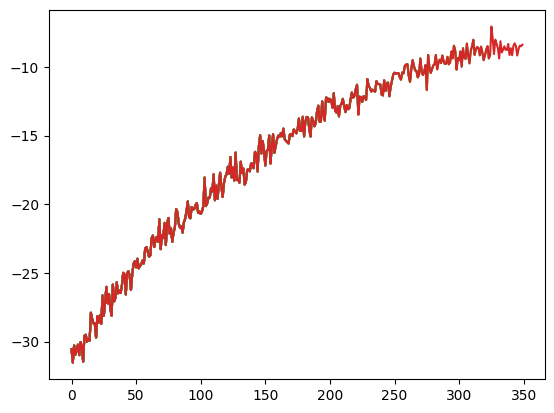

In [15]:
model_name = "RNN"
X, y = prepare_data(model_name, pred_df_train, window_size=2000)
env = GreenhouseTSEnv([X.to_numpy(), y.to_numpy()], tick=4)
agent = prepare_model()
epsilons = Epsilon()
episode_rewards = []
max_episodes = 350
result = main_train(env, agent, episode_rewards, epsilons, max_episodes, model_name, pred_df_test)

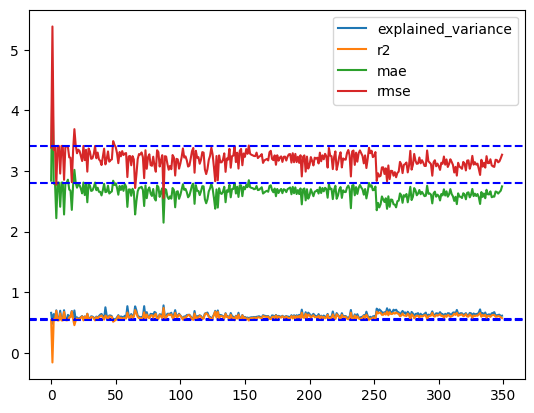

In [16]:
before = {
    "explained_variance":  0.5485,
    "r2":  0.5337,
    "mae":  2.808,
    "mse":  11.6432,
    "rmse":  3.4122,
}

for k, v in result.items():
    if k == "reward" or k == "mse":
        continue
    plt.plot(v, label=k)
    plt.axhline(before[k], color='b', linestyle='--')  

plt.legend()

LSTM

(13952, 3)
Episode: 25, Reward: -28.275317317867252, Epsilon: 0.8822202429488013
Episode: 50, Reward: -27.733012160873415, Epsilon: 0.778312557068642
Episode: 75, Reward: -23.11536111984252, Epsilon: 0.6866430931872001
Episode: 100, Reward: -21.529175138282756, Epsilon: 0.6057704364907278
Episode: 125, Reward: -18.546865530490898, Epsilon: 0.5344229416520513
Episode: 150, Reward: -14.709536036872896, Epsilon: 0.47147873742168567
Episode: 175, Reward: -14.579149971103666, Epsilon: 0.4159480862733536
Episode: 200, Reward: -12.980651963424716, Epsilon: 0.3669578217261671
Episode: 225, Reward: -13.392174200344106, Epsilon: 0.3237376186352221
Episode: 250, Reward: -11.369324014568324, Epsilon: 0.285607880564032
Episode: 275, Reward: -10.83382295484543, Epsilon: 0.2519690537792925
Episode: 300, Reward: -8.800903644561762, Epsilon: 0.22229219984074702
Episode: 325, Reward: -9.065341477489467, Epsilon: 0.2
Episode: 350, Reward: -8.966669689273816, Epsilon: 0.2


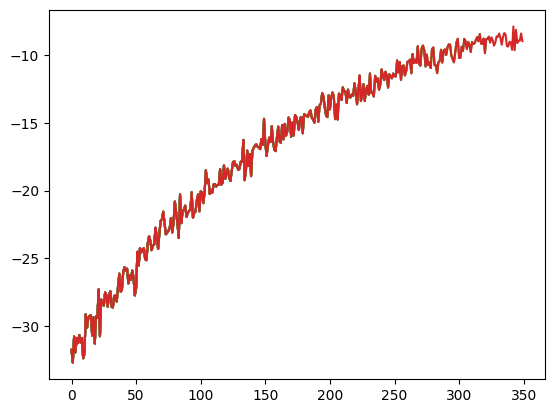

In [17]:
model_name = "LSTM"
X, y = prepare_data(model_name, pred_df_train, window_size=2000)
env = GreenhouseTSEnv([X.to_numpy(), y.to_numpy()], tick=4)
agent = prepare_model()
epsilons = Epsilon()
episode_rewards = []
max_episodes = 350
result = main_train(env, agent, episode_rewards, epsilons, max_episodes, model_name, pred_df_test)

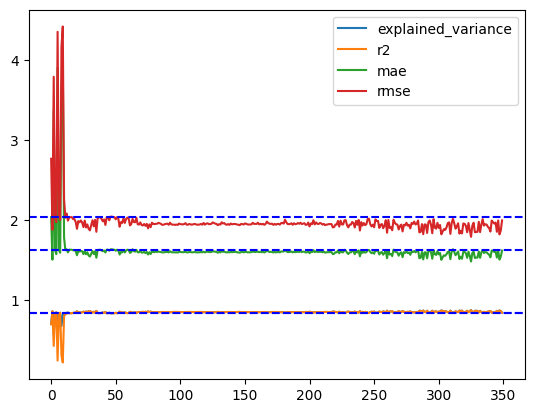

In [19]:
before = {
    "explained_variance":  0.8342,
    "r2":  0.8342,
    "mae":  1.6277,
    "mse":  4.1408,
    "rmse":  2.0349,
}

for k, v in result.items():
    if k == "reward" or k == "mse":
        continue
    plt.plot(v, label=k)
    plt.axhline(before[k], color='b', linestyle='--')  

plt.legend()

Transformer

(13952, 3)
Episode: 25, Reward: -31.493769320774057, Epsilon: 0.8822202429488013
Episode: 50, Reward: -27.983584994411462, Epsilon: 0.778312557068642
Episode: 75, Reward: -24.64831400671008, Epsilon: 0.6866430931872001
Episode: 100, Reward: -22.247494581508622, Epsilon: 0.6057704364907278
Episode: 125, Reward: -18.596272861671455, Epsilon: 0.5344229416520513
Episode: 150, Reward: -16.833085705757146, Epsilon: 0.47147873742168567
Episode: 175, Reward: -16.214018735790255, Epsilon: 0.4159480862733536
Episode: 200, Reward: -14.58897107458116, Epsilon: 0.3669578217261671
Episode: 225, Reward: -13.266697429561626, Epsilon: 0.3237376186352221
Episode: 250, Reward: -12.727835416698435, Epsilon: 0.285607880564032
Episode: 275, Reward: -11.44984945535659, Epsilon: 0.2519690537792925
Episode: 300, Reward: -9.99858848791123, Epsilon: 0.22229219984074702
Episode: 325, Reward: -9.722650628662114, Epsilon: 0.2
Episode: 350, Reward: -9.68501442070008, Epsilon: 0.2


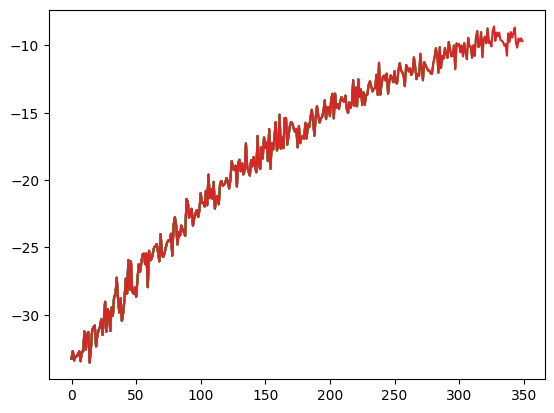

In [19]:
model_name = "Transformer"
X, y = prepare_data(model_name, pred_df_train, window_size=2000)
env = GreenhouseTSEnv([X.to_numpy(), y.to_numpy()], tick=4)
agent = prepare_model()
epsilons = Epsilon()
episode_rewards = []
max_episodes = 350
result = main_train(env, agent, episode_rewards, epsilons, max_episodes, model_name, pred_df_test)

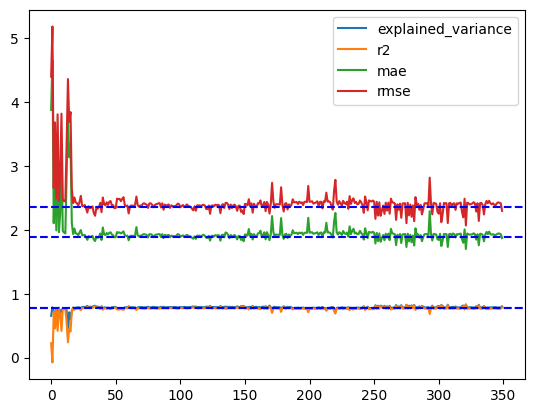

In [20]:
before = {
    "explained_variance":  0.7786,
    "r2":  0.7776,
    "mae":  1.8881,
    "mse":  5.5545,
    "rmse":  2.3568
}

for k, v in result.items():
    if k == "reward" or k == "mse":
        continue
    plt.plot(v, label=k)
    plt.axhline(before[k], color='b', linestyle='--')  
plt.legend()

(13952, 3)
Episode: 25, Reward: -25.953245067501065, Epsilon: 0.8822202429488013
Episode: 50, Reward: -23.57450095329289, Epsilon: 0.778312557068642
Episode: 75, Reward: -20.666944009208688, Epsilon: 0.6866430931872001
Episode: 100, Reward: -18.729709592723843, Epsilon: 0.6057704364907278
Episode: 125, Reward: -17.981464243602712, Epsilon: 0.5344229416520513
Episode: 150, Reward: -16.97099557971953, Epsilon: 0.47147873742168567
Episode: 175, Reward: -14.740399069690692, Epsilon: 0.4159480862733536
Episode: 200, Reward: -13.273475569438936, Epsilon: 0.3669578217261671
Episode: 225, Reward: -12.304823141288749, Epsilon: 0.3237376186352221
Episode: 250, Reward: -12.045816529464723, Epsilon: 0.285607880564032
Episode: 275, Reward: -11.057894124889357, Epsilon: 0.2519690537792925
Episode: 300, Reward: -10.265247845649718, Epsilon: 0.22229219984074702


KeyboardInterrupt: 

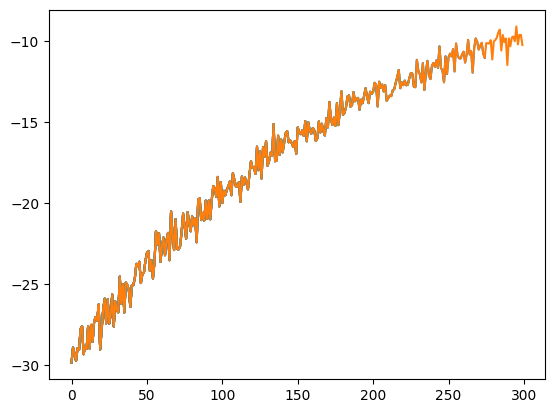

In [32]:
model_name = "Transformer"
tick=3
X, y = prepare_data(model_name, pred_df_train, window_size=2000)
env = GreenhouseTSEnv([X.to_numpy(), y.to_numpy()], tick=tick)
agent = prepare_model()
epsilons = Epsilon()
episode_rewards = []
max_episodes = 350
result = main_train(env, agent, episode_rewards, epsilons, max_episodes, model_name, pred_df_test,
                    tick=tick)


for k, v in result.items():
    if k == "reward" or k == "mse":
        continue
    plt.plot(v, label=k)
    plt.axhline(before[k], color='b', linestyle='--')  
plt.legend()

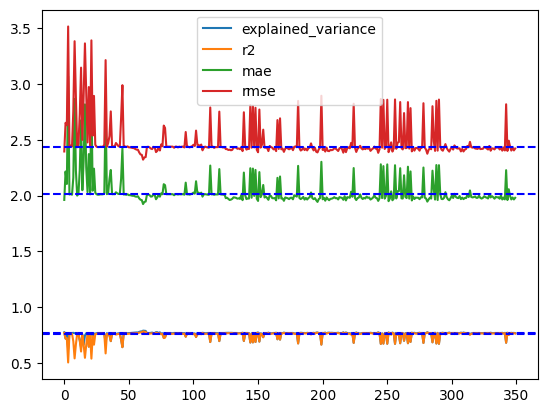

In [33]:
for k, v in result.items():
    if k == "reward" or k == "mse":
        continue
    plt.plot(v, label=k)
    plt.axhline(before[k], color='b', linestyle='--')  
plt.legend()

XGBoost

(13952, 3)
Episode: 25, Reward: -23.66433651949994, Epsilon: 0.8822202429488013
Episode: 50, Reward: -21.277026771499965, Epsilon: 0.778312557068642
Episode: 75, Reward: -18.572802303999982, Epsilon: 0.6866430931872001
Episode: 100, Reward: -16.681541192499996, Epsilon: 0.6057704364907278
Episode: 125, Reward: -15.129087850499994, Epsilon: 0.5344229416520513
Episode: 150, Reward: -13.747069187000006, Epsilon: 0.47147873742168567
Episode: 175, Reward: -11.374953234000007, Epsilon: 0.4159480862733536
Episode: 200, Reward: -10.85846703250002, Epsilon: 0.3669578217261671
Episode: 225, Reward: -9.409047579500017, Epsilon: 0.3237376186352221
Episode: 250, Reward: -8.045345762500018, Epsilon: 0.285607880564032
Episode: 275, Reward: -7.254569352500015, Epsilon: 0.2519690537792925
Episode: 300, Reward: -6.970348030000011, Epsilon: 0.22229219984074702
Episode: 325, Reward: -6.2858006360000065, Epsilon: 0.2
Episode: 350, Reward: -5.670382510499995, Epsilon: 0.2


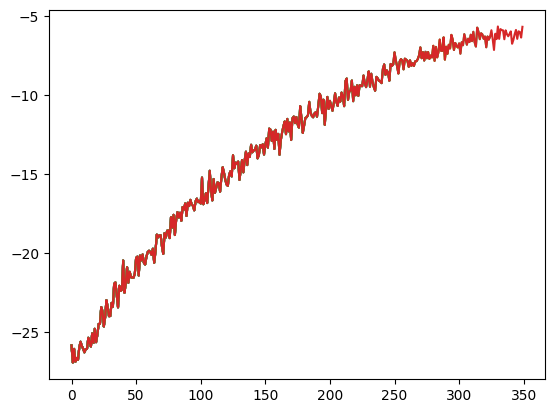

In [21]:
model_name = "XGBoost"
X, y = prepare_data(model_name, pred_df_train, window_size=2000)
env = GreenhouseTSEnv([X.to_numpy(), y.to_numpy()], tick=4)
agent = prepare_model()
epsilons = Epsilon()
episode_rewards = []
max_episodes = 350
result = main_train(env, agent, episode_rewards, epsilons, max_episodes, model_name, pred_df_test)

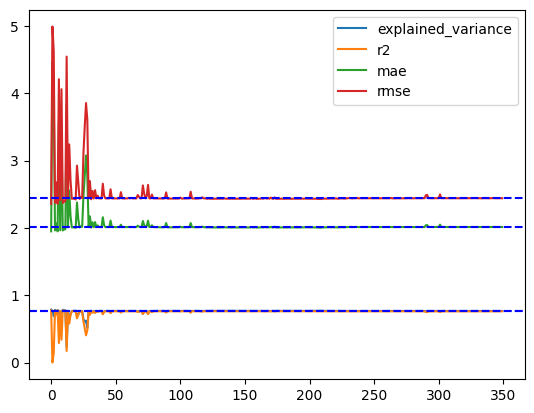

In [22]:
before = {
    "explained_variance":  0.7674,
    "r2":  0.7618,
    "mae":  2.013,
    "mse":  5.9477,
    "rmse":  2.4388
}

for k, v in result.items():
    if k == "reward" or k == "mse":
        continue
    plt.plot(v, label=k)
    plt.axhline(before[k], color='b', linestyle='--')  

plt.legend()

(13952, 3)
Episode: 25, Reward: -18.2507058785, Epsilon: 0.8822202429488013
Episode: 50, Reward: -15.936038285499983, Epsilon: 0.778312557068642
Episode: 75, Reward: -13.807206168000027, Epsilon: 0.6866430931872001
Episode: 100, Reward: -12.285421294500017, Epsilon: 0.6057704364907278
Episode: 125, Reward: -10.93734132200002, Epsilon: 0.5344229416520513
Episode: 150, Reward: -9.799982045999993, Epsilon: 0.47147873742168567
Episode: 175, Reward: -8.73438653350001, Epsilon: 0.4159480862733536
Episode: 200, Reward: -7.947595458000009, Epsilon: 0.3669578217261671
Episode: 225, Reward: -7.943886048500018, Epsilon: 0.3237376186352221
Episode: 250, Reward: -6.521540764000008, Epsilon: 0.285607880564032
Episode: 275, Reward: -5.802462486000016, Epsilon: 0.2519690537792925
Episode: 300, Reward: -5.3746809515, Epsilon: 0.22229219984074702
Episode: 325, Reward: -4.922302119999997, Epsilon: 0.2
Episode: 350, Reward: -4.768165224500005, Epsilon: 0.2


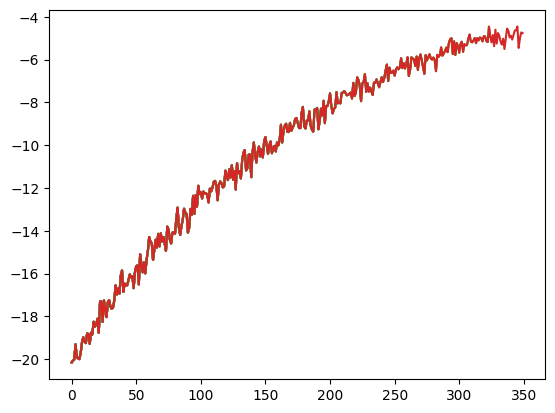

In [26]:
model_name = "XGBoost"
tick = 3
X, y = prepare_data(model_name, pred_df_train, window_size=2000)
env = GreenhouseTSEnv([X.to_numpy(), y.to_numpy()], tick=tick)
agent = prepare_model()
epsilons = Epsilon()
episode_rewards = []
max_episodes = 350
result = main_train(env, agent, episode_rewards, epsilons, max_episodes, model_name, pred_df_test,
                    tick=tick)

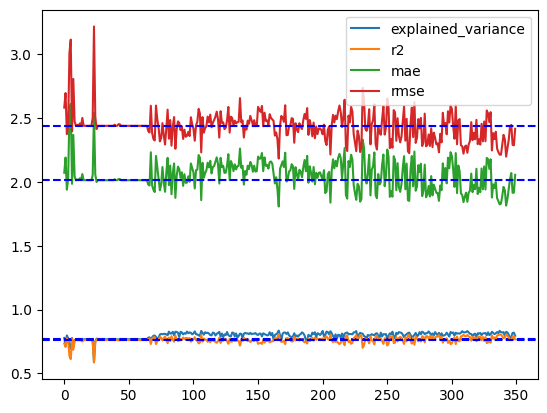

In [27]:
for k, v in result.items():
    if k == "reward" or k == "mse":
        continue
    plt.plot(v, label=k)
    plt.axhline(before[k], color='b', linestyle='--')  

plt.legend()

(13952, 3)
Episode: 25, Reward: -12.900250802000013, Epsilon: 0.8822202429488013
Episode: 50, Reward: -11.311980031000013, Epsilon: 0.778312557068642
Episode: 75, Reward: -10.292146636000016, Epsilon: 0.6866430931872001
Episode: 100, Reward: -8.81107939199999, Epsilon: 0.6057704364907278
Episode: 125, Reward: -7.926763876000013, Epsilon: 0.5344229416520513
Episode: 150, Reward: -6.789170709000011, Epsilon: 0.47147873742168567
Episode: 175, Reward: -6.484249582500011, Epsilon: 0.4159480862733536
Episode: 200, Reward: -5.6854070500000065, Epsilon: 0.3669578217261671
Episode: 225, Reward: -5.312996259999998, Epsilon: 0.3237376186352221
Episode: 250, Reward: -4.354853041499996, Epsilon: 0.285607880564032
Episode: 275, Reward: -4.6619073380000025, Epsilon: 0.2519690537792925
Episode: 300, Reward: -3.9456591790000006, Epsilon: 0.22229219984074702
Episode: 325, Reward: -3.850963598500011, Epsilon: 0.2
Episode: 350, Reward: -3.429160762000008, Epsilon: 0.2


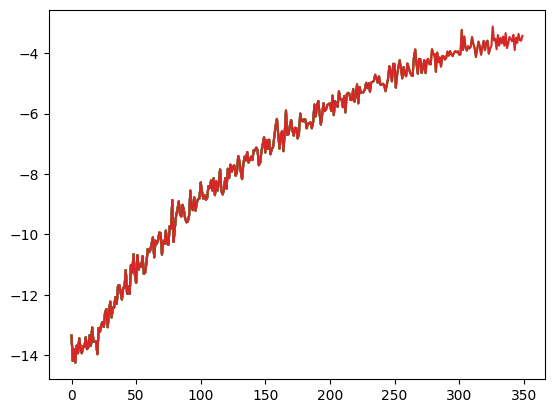

In [29]:
model_name = "XGBoost"
tick = 2
X, y = prepare_data(model_name, pred_df_train, window_size=2000)
env = GreenhouseTSEnv([X.to_numpy(), y.to_numpy()], tick=tick)
agent = prepare_model()
epsilons = Epsilon()
episode_rewards = []
max_episodes = 350
result = main_train(env, agent, episode_rewards, epsilons, max_episodes, model_name, pred_df_test,
                    tick=tick)

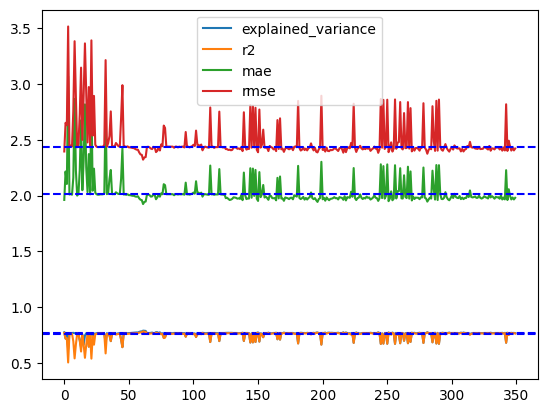

In [30]:

for k, v in result.items():
    if k == "reward" or k == "mse":
        continue
    plt.plot(v, label=k)
    plt.axhline(before[k], color='b', linestyle='--')  

plt.legend()